
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Other approach:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [word, word , \cdots, word]
$$

Issue comes when there is some separator: How to implement it? Idea: Use a random token to represent it.

## Weight update:
 - Make the updatable weights constant and then update it dynamically
 - train it once and them update it dynamically in the forward pass
 - cache weight matrices and train them individually -> this does not train properly (super slow convergence)


In [2]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo

# eventually include tensorboard

In [3]:
# ML resources:
import torch
import os
import matplotlib.pyplot as plt
import gensim
from tqdm.notebook import tqdm
from nltk.tokenize import TweetTokenizer
from datasets import load_dataset

from torch.utils.data import Dataset, DataLoader
from collections import Counter

#others:
import pandas as pd
import numpy as np

In [4]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip wiki-news-300d-1M.vec.zip
! rm wiki-news-300d-1M.vec.zip

--2025-01-20 14:45:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.167.112.53, 3.167.112.129, 3.167.112.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.167.112.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  95.1MB/s    in 8.9s    

2025-01-20 14:45:52 (73.0 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wiki-news-300d-1M.vec   


## DataLoader not implemented yet:

In [5]:
encoder_model = gensim.models.KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec",binary = False)

In [6]:
## We create the embeddings and find the vocab
import copy
unk_token = '<unk>'
embedding_vectors = torch.from_numpy(encoder_model.vectors)
pretrained_vocab = copy.deepcopy(encoder_model.index_to_key)
pretrained_vocab[:0] = [unk_token]

stoi = {word: i for i, word in enumerate(pretrained_vocab)}
itos = {i: word for i, word in enumerate(pretrained_vocab)}

pretrained_embeddings = torch.cat((torch.zeros(1,embedding_vectors.shape[1]),embedding_vectors))


In [7]:
tok = TweetTokenizer()

def tokenize_text_extend_emotions(text,emotion,stoi): ## utteration : string -> list of tokenized words : [int]
  text = tok.tokenize(text)
  text = [stoi[word] if word in stoi else stoi['<unk>'] for word in text]
  return text, [emotion]*len(text)

def Preprocess_data(X,Y):
  X_flat, Y_flat = [], []
  for i in tqdm(range(len(X))):
    for j in range(len(X[i])):
      text, emotion = tokenize_text_extend_emotions(X[i][j],Y[i][j],stoi)
      X_flat.extend(text)
      Y_flat.extend(emotion)
  return X_flat[:-1], Y_flat[:-1], X_flat[1:], Y_flat[1:]




In [8]:
## annoying to adapt a bit

class DailyDialogDataset(Dataset):
  def __init__(self, texts, emotions,texts_target,emotions_target):
  # Dataset object for Daily Dialog dataset
    self.texts = texts               ## text with embeddings
    self.emotions = emotions               ## emotion with embeddings
    self.texts_target = texts_target   ## text for CrossEntropy
    self.emotions_target = emotions_target   ## emotions for CrossEntropy

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
        'texts': self.texts[idx],
        'emotions': self.emotions[idx],
        'texts_target': self.texts_target[idx],
        'emotions_target': self.emotions_target[idx]
    }
    return item



Here we will extract the data:

In [9]:

data = load_dataset('daily_dialog')
X_train = data['train']['dialog']
Y_train = data['train']['emotion']

X_test = data['test']['dialog']
Y_test = data['test']['emotion']

X_val = data['validation']['dialog']
Y_val = data['validation']['emotion']


for lx,ly in zip(X_train,Y_train):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_val,Y_val):
  assert(len(lx) == len(ly))
for lx,ly in zip(X_test,Y_test):
  assert(len(lx) == len(ly))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


While dataloader is not implemented, we have this:

In [10]:
print(tokenize_text_extend_emotions(X_train[0][1],Y_train[0][1],stoi))


X_train,Y_train,X_train_target,Y_train_target = Preprocess_data(X_train,Y_train)
X_test,Y_test,X_test_target,Y_test_target = Preprocess_data(X_test,Y_test)
X_val,Y_val,X_val_target, Y_val_target = Preprocess_data(X_val,Y_val)



([266, 198, 12, 14, 23359, 48, 14, 229, 35, 174, 15, 107, 6584, 3], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:

print("train size: ",len(X_train))
print("test size: ",len(X_test))
print("validation size: ",len(X_val))


train size:  1185914
test size:  106626
validation size:  108922


Now we train w2v:

In [12]:
batch_size = 800
train_data = DailyDialogDataset(X_train,Y_train,X_train_target,Y_train_target)
test_data = DailyDialogDataset(X_test,Y_test,X_test_target,Y_test_target)
val_data = DailyDialogDataset(X_val,Y_val,X_val_target,Y_val_target)

train_loader = DataLoader(train_data, batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle = True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle = True)


# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (Not implemented yet)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [13]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, emo_dim, n_emotion, n_vocab):
    super(SimpleModel,self).__init__()
    ## word_dim = 300

    self.embedding_layer_text = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
    self.embedding_layer_emotion = nn.Embedding(n_emotion, emo_dim)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(300,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)

    # self.Linear_utt3.requires_grad = False

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(emo_dim,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    # self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final1 = nn.Linear(380, 180)
    self.Linear_utt_final2 = nn.Linear(180, 90)
    self.Linear_utt_final3 = nn.Linear(90, 15)
    self.Linear_utt_final = nn.Linear(15, n_vocab)


    self.Linear_emo_final = nn.Linear(380, n_emotion)

    self.softmax = nn.Softmax(dim=0)



  def forward(self, text, emotion):

    with torch.no_grad():
      text = self.embedding_layer_text(text)
    text = self.Linear_utt1(text)
    text = self.Linear_utt2(text)
    text = self.Linear_utt3(text)

    emotion = self.embedding_layer_emotion(emotion)
    emotion = self.Linear_emo1(emotion)
    emotion = self.Linear_emo2(emotion)
    emotion = self.Linear_emo3(emotion)

    z = torch.cat((text,emotion),-1)
    z = self.Linear_fus(z)
    #text = torch.cat((z,text),-1)
    #text = self.Linear_utt_final1(text)
    #text = self.Linear_utt_final2(text)
    #text = self.Linear_utt_final3(text)
    #text = self.Linear_utt_final(text)
    #text = self.softmax(text)
    emotion = torch.cat((z,emotion),-1)
    emotion = self.Linear_emo_final(emotion)
    emotion = self.softmax(emotion)

    return emotion

In [14]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## normal train function
def train(model, epochs, device):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  model.zero_grad()
  loss = 0
  loss_to_plot = []
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):
      batch = {
               'texts': batch['texts'].to(device),
               'emotions': batch['emotions'].to(device),
             # 'texts_target': batch['texts_target'].to(device),
               'emotions_target': batch['emotions_target'].to(device)
              }
      optimizer.zero_grad()
      pe  = model.forward(batch['texts'],batch['emotions'])
      loss = loss_fn(pe, batch['emotions_target']) # + loss_fn(pt, batch['text_target'])
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
    loss_to_append = sum(losses)/len(losses)
    loss_to_plot.append(loss_to_append)
    print(f"loss: ",loss_to_append)
  return loss_to_plot


In [15]:
device = activate_gpu()
fn = nn.CrossEntropyLoss()
model = SimpleModel(50,7,len(stoi))
print(device)

DEVICE =  CPU blue
cpu


Epoch 1/7


  0%|          | 0/1483 [00:00<?, ?it/s]

loss:  1.9389765591373818
Epoch 2/7


  0%|          | 0/1483 [00:00<?, ?it/s]

loss:  1.9388410485602678
Epoch 3/7


  0%|          | 0/1483 [00:00<?, ?it/s]

loss:  1.9388420253851408
Epoch 4/7


  0%|          | 0/1483 [00:00<?, ?it/s]

loss:  1.9388326457120724
Epoch 5/7


  0%|          | 0/1483 [00:00<?, ?it/s]

loss:  1.9411641581992563
Epoch 6/7


  0%|          | 0/1483 [00:00<?, ?it/s]

loss:  1.941232809406314
Epoch 7/7


  0%|          | 0/1483 [00:00<?, ?it/s]

loss:  1.941243475221414


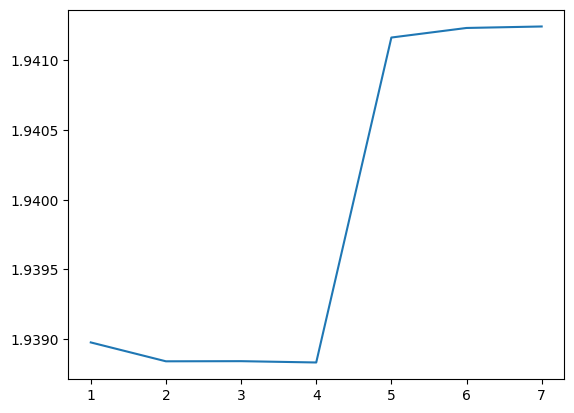

In [16]:
epochs = 7

losses = train(model,epochs,device)
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [23]:
def compute_test_loss(model,loss_fn,data_loader,device):
  model.eval()
  losses = []
  accs = []
  preds = []
  prec = 0
  trues = []
  pred_words = []
  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'texts' : batch['texts'].to(device),
             'emotions': batch['emotions'].to(device),
             'texts_target': batch['texts_target'].to(device),
             'emotions_target': batch['emotions_target'].to(device)}
    #pt, pe  = model.forward(batch['text'],batch['emot'])

    pe  = model.forward(batch['texts'],batch['emotions'])
    index_pred = torch.argmax(pe,1)
    correct = (batch['emotions_target'].flatten() == index_pred.flatten()).float().sum()

    acc = correct/len(index_pred.flatten())
    accs.append(acc.item())

    loss = loss_fn(pe, batch['emotions_target']) # + loss_fn(pt, batch['text_target'])
    losses.append(loss.item())

    trues.extend(batch['emotions_target'].flatten().tolist())
    preds.extend(index_pred.tolist())

  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds
trues, preds = compute_test_loss(model,nn.CrossEntropyLoss(),val_loader,device)
names = [f'{i}' for i in range(1,8)]



  0%|          | 0/137 [00:00<?, ?it/s]

average loss:  1.941324755223128
average acc:  0.788298732390369


In [24]:
#for i,w,q in zip(trues[:50],preds[:50],pred_words[:50]):
#  print(i,w,itos_train1[q.item()])
#
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
confusion_matrix(trues,preds)

              precision    recall  f1-score   support

           1       0.99      0.79      0.88     97134
           2       0.00      0.00      0.00      1288
           3       0.00      0.00      0.00        47
           4       0.01      0.96      0.01       153
           5       0.94      0.94      0.94      7726
           6       0.58      0.94      0.71      1288
           7       1.00      0.56      0.72      1286

    accuracy                           0.79    108922
   macro avg       0.50      0.60      0.47    108922
weighted avg       0.97      0.79      0.87    108922



array([[76777,    92,     0, 19702,   460,   103,     0],
       [   38,     0,     1,   458,     5,   786,     0],
       [   47,     0,     0,     0,     0,     0,     0],
       [    6,     0,     0,   147,     0,     0,     0],
       [  307,     7,     0,   164,  7244,     4,     0],
       [   38,     3,     0,    28,     5,  1214,     0],
       [   66,   219,   243,    22,    12,     3,   721]])